In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
juvenile_history_path = (
    "D:/Cleaned-data/Juvenile_cases_cleaned.csv/Juvenile_cases_cleaned.csv"
)
juvenile_history = pd.read_csv(
    filepath_or_buffer=juvenile_history_path,
    dtype={
        "idnJuvenileHistory": "Int64",
        "idnCase": "Int64",
        "idnProceeding": "Int64",
        "idnJuvenile": "category",
    },
    low_memory=False,
)

### JuvenileHistory Table

The `JuvenileHistory` table is a **junction table** that contains foreign keys linking to core case tables and lookup tables. It represents many-to-many relationships between juveniles and immigration proceedings.

**Key columns:**
- `idnJuvenileHistory` — Primary key
- `idnCase` — Foreign key to the `Case` table
- `idnProceeding` — Foreign key to the `Proceeding` table
- `idnJuvenile` — Foreign key to the `Lookup Juvenile` table

This table acts as a bridge, allowing multiple juveniles to be associated with multiple cases and proceedings.

In [25]:
juvenile_history.head()

,IDNCASE,NAT,LANG,CUSTODY,CASE_TYPE,LATEST_HEARING,LATEST_CAL_TYPE,DATE_OF_ENTRY,C_BIRTHDATE,GENDER,DATE_DETAINED,DATE_RELEASED
0,13758313,GT,SP,N,RMV,NaN,NaN,2024-01-21,2008-02-01,F,NaN,NaN
1,14870586,MX,SP,D,RFR,2025-02-04,I,NaN,NaN,NaN,2025-01-22,NaN
2,14870588,GT,SP,R,WHO,2025-07-31,M,NaN,1997-06-01,F,2025-01-29,2025-02-06 00:00:00.000
3,13816559,MX,SP,N,RMV,2027-02-18,I,NaN,2020-05-01,M,NaN,NaN
4,13816560,MX,SP,N,RMV,2027-02-18,I,NaN,2021-05-01,F,NaN,NaN


In [26]:
juvenile_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1858773 entries, 0 to 1858772
Data columns (total 12 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   IDNCASE          int64 
 1   NAT              object
 2   LANG             object
 3   CUSTODY          object
 4   CASE_TYPE        object
 5   LATEST_HEARING   object
 6   LATEST_CAL_TYPE  object
 7   DATE_OF_ENTRY    object
 8   C_BIRTHDATE      object
 9   GENDER           object
 10  DATE_DETAINED    object
 11  DATE_RELEASED    object
dtypes: int64(1), object(11)
memory usage: 170.2+ MB


In [27]:
rows = juvenile_history.shape[0]
unique_juvenile_case_ids_len = len(juvenile_history["IDNCASE"].unique())
case_counts = juvenile_history["IDNCASE"].value_counts()

print(f"Since 2008, the EOIR database contains {rows:,} juvenile records.")
print(
    f"The dataset includes {unique_juvenile_case_ids_len:,} unique juvenile case IDs."
)
print(f"Median records per case ID: {case_counts.median()}")
print(f"Average records per case ID: {case_counts.mean():.2f}")
print(f"Cases with only one record: {(case_counts == 1).sum()}")

Since 2008, the EOIR database contains 1,858,773 juvenile records.
The dataset includes 1,858,773 unique juvenile case IDs.
Median records per case ID: 1.0
Average records per case ID: 1.00
Cases with only one record: 1858773


In [29]:
lookup_juvenile_path = r"D:\New folder\Lookup\tblLookup_Juvenile.csv"
lookup_juvenile = pd.read_csv(
    filepath_or_buffer=lookup_juvenile_path,
    delimiter="\t",
    dtype={"idnJuvenile": "category"},
)

In [30]:
display(lookup_juvenile)

,idnJuvenile,strCode,strDescription,DATCREATEDON,DATMODIFIEDON
0,1,J,Juvenile Case,2014-09-06 11:03:55.993,2017-04-07 21:42:18.000
1,2,J1,Juvenile has been released to guardian or has ...,2014-09-06 11:03:56.033,2017-04-07 21:42:34.000
2,3,J2,Unaccompanied Juvenile - Asylum,2014-09-06 11:03:56.033,2017-04-07 21:42:41.000
3,4,UJ,Unaccompanied Juvenile,2014-09-06 11:03:56.033,2014-09-06 17:39:29.000
4,5,NaN,Not Applicable,2017-10-20 22:32:47.537,2017-10-20 22:32:47.537
5,6,AJ,Accompanied Juvenile,2017-10-20 22:32:47.537,2017-10-20 22:32:47.537


In [ ]:
missing_count = juvenile_history[""].isna().sum()
print(f"Missing idnJuvenile values: {missing_count}")

In [ ]:
juvenile_history_with_lookup = juvenile_history.merge(
    lookup_juvenile, how="left", on="idnJuvenile"
)

In [ ]:
juvenile_history_with_lookup.columns

In [16]:
juvenile_history_with_lookup = juvenile_history_with_lookup[
    ["idnJuvenileHistory", "idnCase", "idnProceeding", "strCode", "strDescription"]
]

In [17]:
juvenile_history_with_lookup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2857093 entries, 0 to 2857092
Data columns (total 5 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   idnJuvenileHistory  Int64 
 1   idnCase             Int64 
 2   idnProceeding       Int64 
 3   strCode             object
 4   strDescription      object
dtypes: Int64(3), object(2)
memory usage: 117.2+ MB


In [18]:
juvenile_history_with_lookup.head()

,idnJuvenileHistory,idnCase,idnProceeding,strCode,strDescription
0,5,2046990,3200129,J,Juvenile Case
1,6,2047179,3199488,J,Juvenile Case
2,7,2047179,3199489,J,Juvenile Case
3,8,2047199,3199497,J,Juvenile Case
4,9,2047199,3199498,J,Juvenile Case


In [19]:
juvenile_history_with_lookup["strCode"] = juvenile_history_with_lookup[
    "strCode"
].fillna("Unknown")
juvenile_history_with_lookup["strDescription"] = juvenile_history_with_lookup[
    "strDescription"
].fillna("Not Applicable")

In [20]:
juvenile_history_with_lookup["strCode"].value_counts(dropna=False)

strCode
Unknown    1883374
UJ          452017
J           233667
AJ          227915
J1           59386
J2             734
Name: count, dtype: int64

The plot below shows the frequency of juvenile types using the `strCode` field from the `juvenile_history_with_lookup` dataset.  
Missing or unmatched `idnJuvenile` values were labeled as `"Unknown"` to ensure the dataset is complete and all records are represented.

A **logarithmic scale** is applied to the y-axis because the data is highly imbalanced — for example, the `"Unknown"` category includes over 1.8 million records, while `"AJ"` has only 734.  
Using a log scale allows smaller categories to remain visible and interpretable without compressing the larger bars too severely.

Actual record counts are displayed above each bar for clarity.

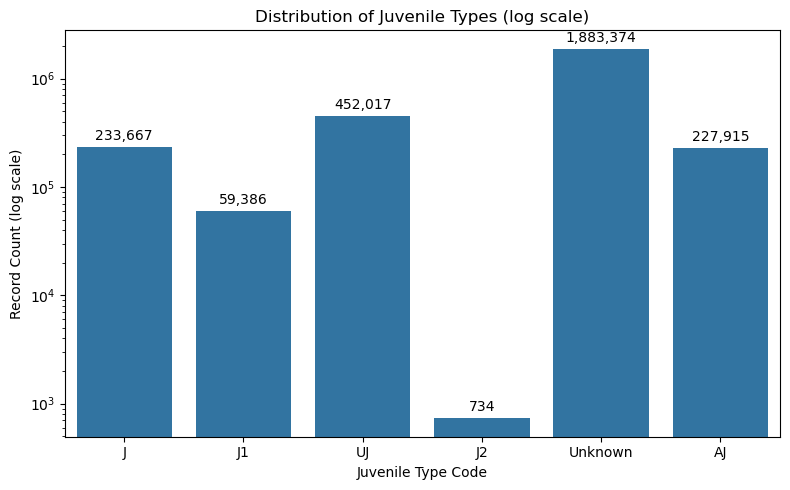

In [21]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=juvenile_history_with_lookup, x="strCode")

ax.set_yscale("log")
ax.set_title("Distribution of Juvenile Types (log scale)")
ax.set_xlabel("Juvenile Type Code")
ax.set_ylabel("Record Count (log scale)")

for container in ax.containers:
    ax.bar_label(
        container,
        labels=[f"{int(v):,}" for v in container.datavalues],
        fontsize=10,
        padding=3,
    )

plt.tight_layout()
plt.show()

### Cases Table

The `Cases` table has already been cleaned and filtered to include only **juvenile cases**, based on a prior match using the `idnCase` field.  
Originally, the raw dataset contained over **11.7 million** records; after filtering, only juvenile-related entries were retained.

The dataset includes the following columns:

- `IDNCASE` – Primary key identifying each case
- `NAT` – Nationality of the alien
- `LANG` – Primary language spoken by the alien
- `CUSTODY` – Current custody status of the alien
- `CASE_TYPE` – Type of immigration case
- `LATEST_HEARING` – Date of the latest appearance before an immigration judge
- `LATEST_CAL_TYPE` – Type of hearing scheduled (`I` for individual, `M` for master)
- `DATE_OF_ENTRY` – Date the alien entered the United States
- `C_BIRTHDATE` – Birthdate of the alien
- `GENDER` – Sex of the alien
- `DATE_DETAINED` – Date the alien was detained
- `DATE_RELEASED` – Actual release date of the detained alien
- `DETENTION_DATE` – Date the alien entered the current detention facility

This table serves as the core source for analyzing case-level demographics, legal status, and custody timelines for juvenile immigration cases.

In [3]:
cases_path = "D:/Cleaned-data/Juvenile_cases_cleaned.csv/Juvenile_cases_cleaned.csv"

# the dtype schema below was pulled directly from the 02_clean_core_tables.ipynb notebook in the 2_data_preparation/notebooks/ folder
dtype = {
    "IDNCASE": "Int64",
    "NAT": "category",
    "LANG": "category",
    "CUSTODY": "category",
    "CASE_TYPE": "category",
    "LATEST_CAL_TYPE": "category",
    "GENDER": "category",
}

parse_dates = [
    "LATEST_HEARING",
    "DATE_OF_ENTRY",
    "C_BIRTHDATE",
    "DATE_DETAINED",
    "DATE_RELEASED",
]

In [6]:
cases = pd.read_csv(
    filepath_or_buffer=cases_path,
    dtype=dtype,
    parse_dates=parse_dates,
    low_memory=False,
)

In [7]:
cases.shape

(1858773, 12)

In [8]:
cases.head()

,IDNCASE,NAT,LANG,CUSTODY,CASE_TYPE,LATEST_HEARING,LATEST_CAL_TYPE,DATE_OF_ENTRY,C_BIRTHDATE,GENDER,DATE_DETAINED,DATE_RELEASED
0,13758313,GT,SP,N,RMV,NaT,NaN,2024-01-21,2008-02-01,F,NaN,NaN
1,14870586,MX,SP,D,RFR,2025-02-04,I,NaN,NaT,NaN,2025-01-22,NaN
2,14870588,GT,SP,R,WHO,2025-07-31,M,NaN,1997-06-01,F,2025-01-29,2025-02-06 00:00:00.000
3,13816559,MX,SP,N,RMV,2027-02-18,I,NaN,2020-05-01,M,NaN,NaN
4,13816560,MX,SP,N,RMV,2027-02-18,I,NaN,2021-05-01,F,NaN,NaN


In [9]:
cases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1858773 entries, 0 to 1858772
Data columns (total 12 columns):
 #   Column           Dtype         
---  ------           -----         
 0   IDNCASE          Int64         
 1   NAT              category      
 2   LANG             category      
 3   CUSTODY          category      
 4   CASE_TYPE        category      
 5   LATEST_HEARING   datetime64[ns]
 6   LATEST_CAL_TYPE  category      
 7   DATE_OF_ENTRY    object        
 8   C_BIRTHDATE      datetime64[ns]
 9   GENDER           category      
 10  DATE_DETAINED    object        
 11  DATE_RELEASED    object        
dtypes: Int64(1), category(6), datetime64[ns](2), object(3)
memory usage: 101.1+ MB


After using `parse_dates`, some date columns can remain as strings. The following steps address that:

- Strip leading/trailing whitespace  
- Convert to `datetime64[ns]`, coercing unparseable entries to `NaT` 

In [10]:
date_cols = ["DATE_OF_ENTRY", "DATE_DETAINED", "DATE_RELEASED"]

for col in date_cols:
    cases[col] = pd.to_datetime(
        cases[col].str.strip(),
        errors="coerce",
    )

In [11]:
null_counts = cases.isna().sum()
percent_missing = (null_counts / len(cases)) * 100

missing_summary = pd.DataFrame(
    {"Missing Count": null_counts, "Missing %": percent_missing.round(2)}
).sort_values(by="Missing Count", ascending=False)

display(missing_summary)

,Missing Count,Missing %
DATE_RELEASED,1411890,75.96
DATE_DETAINED,1090739,58.68
DATE_OF_ENTRY,493393,26.54
GENDER,488542,26.28
C_BIRTHDATE,446731,24.03
LATEST_CAL_TYPE,303570,16.33
LATEST_HEARING,296822,15.97
NAT,3057,0.16
LANG,1692,0.09
CUSTODY,4,0.00


In [12]:
gender = cases["GENDER"].value_counts().reset_index()
gender.columns = ["GENDER", "COUNT"]

gender["RATIO (%)"] = (gender["COUNT"] / gender["COUNT"].sum()) * 100
gender["RATIO (%)"] = gender["RATIO (%)"].round()

display(gender)

,GENDER,COUNT,RATIO (%)
0,M,875507,64.0
1,F,494724,36.0


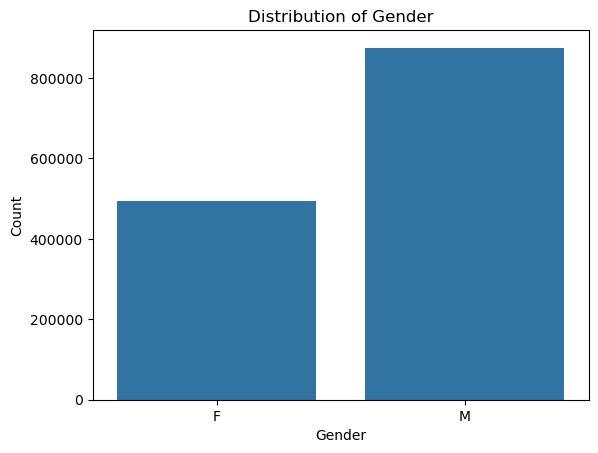

In [13]:
sns.barplot(data=gender, x="GENDER", y="COUNT")
plt.title("Distribution of Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

In [14]:
cases["NAT"].value_counts().head(20)

NAT
GT    428582
HO    380966
MX    273583
ES    215345
CU     62003
NU     53242
BR     52374
VE     51313
CO     51017
EC     37500
IN     35092
HA     22693
PE     21973
DR     16895
CH     15869
TU     12286
RU     12263
BG      6912
JM      5637
RO      5187
Name: count, dtype: int64

In [15]:
cases["LANG"].value_counts().head(20)

LANG
SP     1504441
ENG      80068
POR      45998
PUN      21887
CRE      19854
SP       17525
RUS      15194
MAN      14250
TU       11688
MAM      11365
QUI       8904
UNK       8030
HIN       7631
KON       6442
BEN       6391
KEK       5763
AR        4825
UZB       3454
FR        3442
ARM       3338
Name: count, dtype: int64

C_BIRTHDATE originally lacked day-level precision and was defaulted to the first day of the month during datetime conversion.

In [16]:
cases[["DATE_OF_ENTRY", "C_BIRTHDATE"]]

,DATE_OF_ENTRY,C_BIRTHDATE
0,2024-01-21,2008-02-01
1,NaT,NaT
2,NaT,1997-06-01
3,NaT,2020-05-01
4,NaT,2021-05-01
...,...,...
1858768,2019-06-03,2004-11-01
1858769,2018-04-03,NaT
1858770,2014-03-24,2003-11-01
1858771,2023-04-23,1993-03-01


#### The calculated mean, median, minimum, and standard deviation of age at entry were within expected ranges; however, the maximum age was 118 years, indicating a likely error in the recoding of birth dates or entry dates for one or more juveniles.


In [25]:
# Drop rows with missing birthdate or entry date
df_cleaned = cases.dropna(subset=["C_BIRTHDATE", "DATE_OF_ENTRY"]).copy()

# Calculate age at entry
df_cleaned["AGE_AT_ENTRY"] = (df_cleaned["DATE_OF_ENTRY"] - df_cleaned["C_BIRTHDATE"]).dt.days / 365.25

# Filter out negative ages
df_cleaned = df_cleaned[df_cleaned["AGE_AT_ENTRY"] >= 0]

# Calculate statistics from the cleaned AGE_AT_ENTRY column
mean_age = df_cleaned["AGE_AT_ENTRY"].mean()
median_age = df_cleaned["AGE_AT_ENTRY"].median()
min_age = df_cleaned["AGE_AT_ENTRY"].min()
max_age = df_cleaned["AGE_AT_ENTRY"].max()
std_age = df_cleaned["AGE_AT_ENTRY"].std()

# Print results
print(f"Mean age at entry: {mean_age:.2f} years")
print(f"Median age at entry: {median_age:.2f} years")
print(f"Min age at entry: {min_age:.2f} years")
print(f"Max age at entry: {max_age:.2f} years")
print(f"Standard deviation: {std_age:.2f} years")


Mean age at entry: 19.68 years
Median age at entry: 17.14 years
Min age at entry: 0.00 years
Max age at entry: 118.00 years
Standard deviation: 12.15 years


### PLot of age at entry 

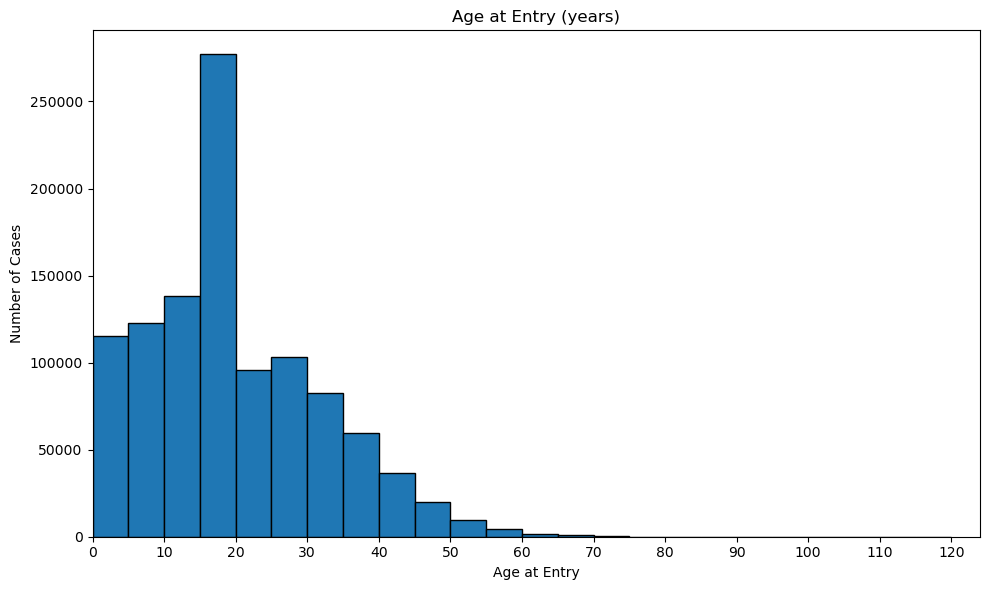

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure dates are valid and calculate AGE_AT_ENTRY
df_cleaned = cases.dropna(subset=["C_BIRTHDATE", "DATE_OF_ENTRY"]).copy()
df_cleaned["AGE_AT_ENTRY"] = (
    df_cleaned["DATE_OF_ENTRY"] - df_cleaned["C_BIRTHDATE"]
).dt.days / 365.25
# df_cleaned = df_cleaned[df_cleaned["AGE_AT_ENTRY"] < 21]
df_cleaned_error = df_cleaned[df_cleaned["AGE_AT_ENTRY"] > 0]
# Define bins
step = 5
max_age = df_cleaned["AGE_AT_ENTRY"].max()
bins = np.arange(0, np.ceil(max_age) + step, step)

# Plot histogram
plt.figure(figsize=(10, 6))
# plt.hist(df_cleaned["AGE_AT_ENTRY"], bins=bins, edgecolor="black")
plt.hist(df_cleaned_error["AGE_AT_ENTRY"], bins=bins, edgecolor="black")
# Customize x-axis ticks
plt.xticks(np.arange(0, np.ceil(max_age) + step, 10))

# Labels and formatting
plt.title("Age at Entry (years)")
plt.xlabel("Age at Entry")
plt.ylabel("Number of Cases")
plt.xlim(0, np.ceil(max_age) + step)
plt.tight_layout()
plt.show()

### Plot of the age at entry with the condition that age <21

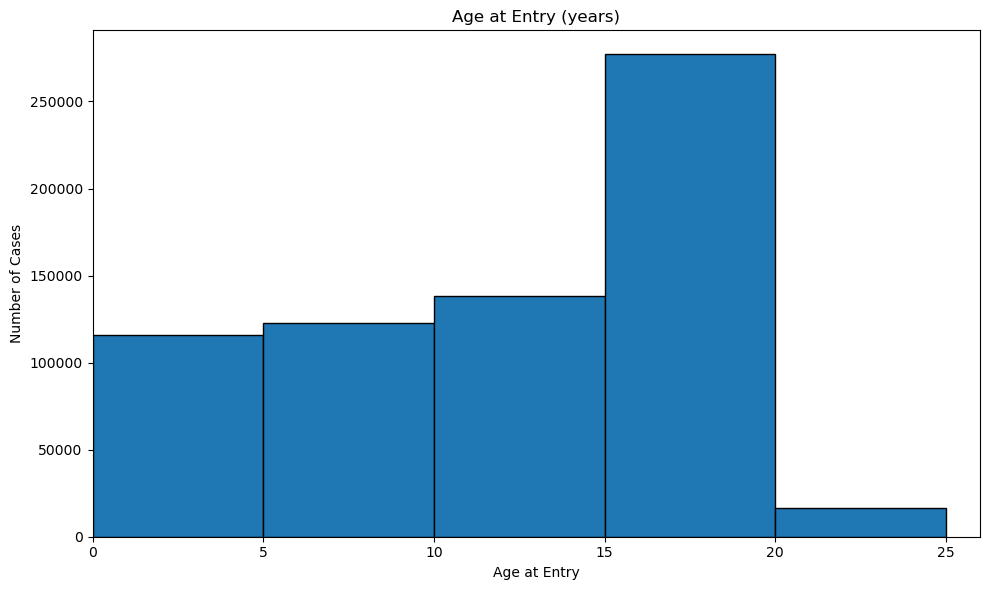

In [35]:
step = 5
max_age = df_cleaned["AGE_AT_ENTRY"].max()
bins = np.arange(0, np.ceil(max_age) + step, step)


df_cleaned = df_cleaned[df_cleaned["AGE_AT_ENTRY"] < 21]
plt.figure(figsize=(10, 6))
plt.hist(df_cleaned["AGE_AT_ENTRY"], bins=bins, edgecolor="black")
# Customize x-axis ticks
plt.xticks(np.arange(0, np.ceil(max_age) + step, 5))

# Labels and formatting
plt.title("Age at Entry (years)")
plt.xlabel("Age at Entry")
plt.ylabel("Number of Cases")
plt.xlim(0, np.ceil(max_age) + step)
plt.tight_layout()
plt.show()

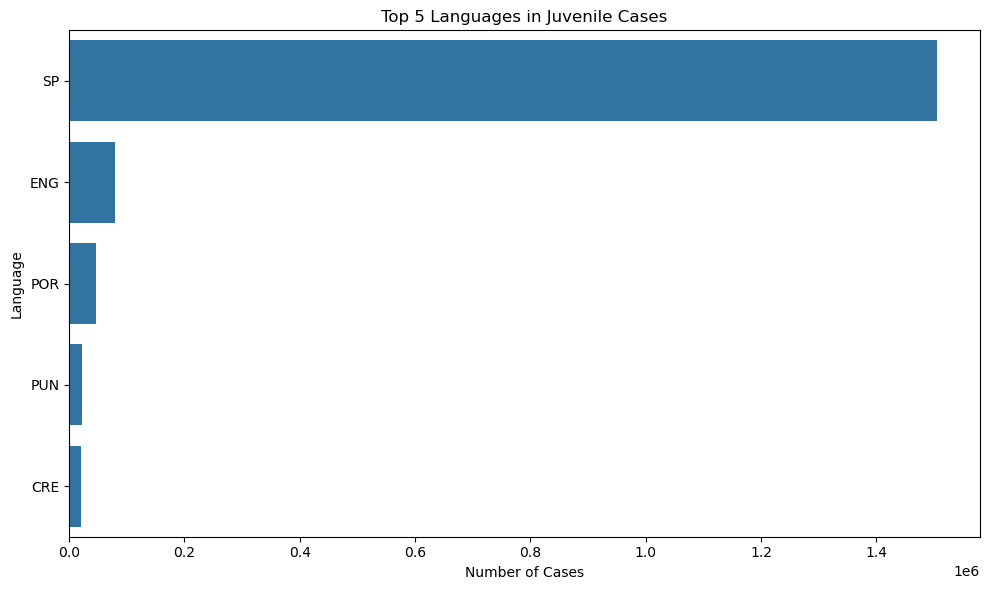

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=cases, y="LANG", order=cases["LANG"].value_counts().index[:5])
plt.title("Top 5 Languages in Juvenile Cases")
plt.xlabel("Number of Cases")
plt.ylabel("Language")
plt.tight_layout()
plt.show()

## Nationalities Abbreviations  

| Code   | Country                                                                              |
| ------ | ------------------------------------------------------------------------------------ |
| **GT** | Guatemala                                                                            |
| **HO** | Honduras                                                                             |
| **MX** | Mexico                                                                               |
| **ES** | El Salvador                                                                          |
| **CU** | Cuba                                                                                 |
| **NU** | Nicaragua (commonly `NI`, double-check this one)                                     |
| **BR** | Brazil                                                                               |
| **VE** | Venezuela                                                                            |
| **CO** | Colombia                                                                             |
| **EC** | Ecuador                                                                              |
| **IN** | India                                                                                |
| **HA** | Haiti                                                                                |
| **PE** | Peru                                                                                 |
| **DR** | Dominican Republic                                                                   |
| **CH** | Switzerland (but often **China** in legacy immigration systems; confirm with lookup) |
| **TU** | Turkey                                                                               |
| **RU** | Russia                                                                               |
| **BG** | Bulgaria                                                                             |
| **JM** | Jamaica                                                                              |
| **RO** | Romania                                                                              |


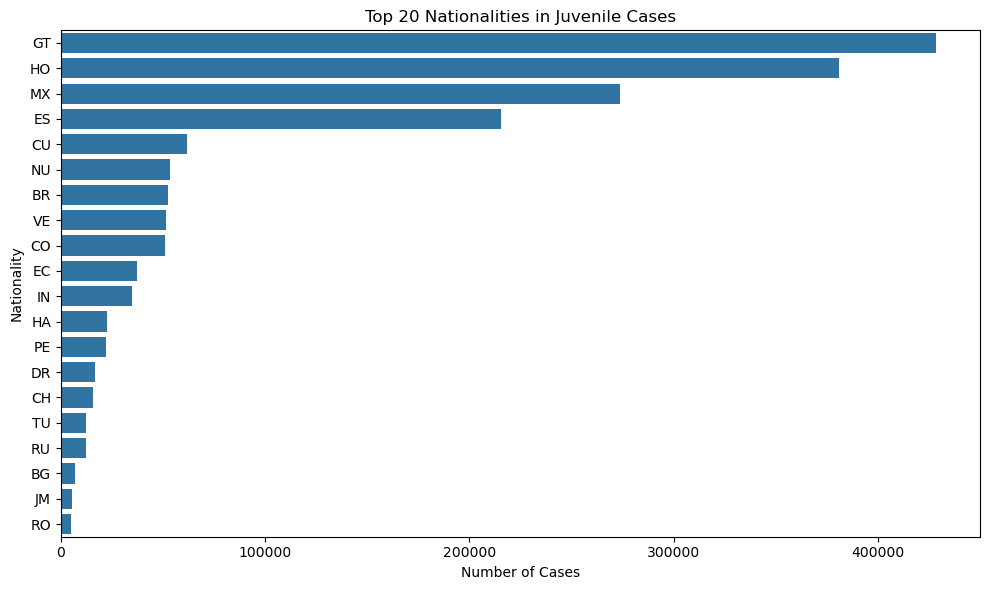

In [136]:
plt.figure(figsize=(10, 6))
sns.countplot(data=cases, y="NAT", order=cases["NAT"].value_counts().index[:20])
plt.title("Top 20 Nationalities in Juvenile Cases")
plt.xlabel("Number of Cases")
plt.ylabel("Nationality")
plt.tight_layout()
plt.show()

### 📊 Detention Duration Summary

We took a sample of 100 cases and calculated the **mean number of days juveniles were detained** within that sample.  
To provide broader context, we also calculated the **mean detention duration across all juvenile cases** in the dataset.  
This comparison helps illustrate the average length of detention for both a small representative subset and the entire population, giving us insight into typical detention periods for juveniles.

Mean detention days (all cases): 61.81
Mean detention days (first 1000 cases): 65.91


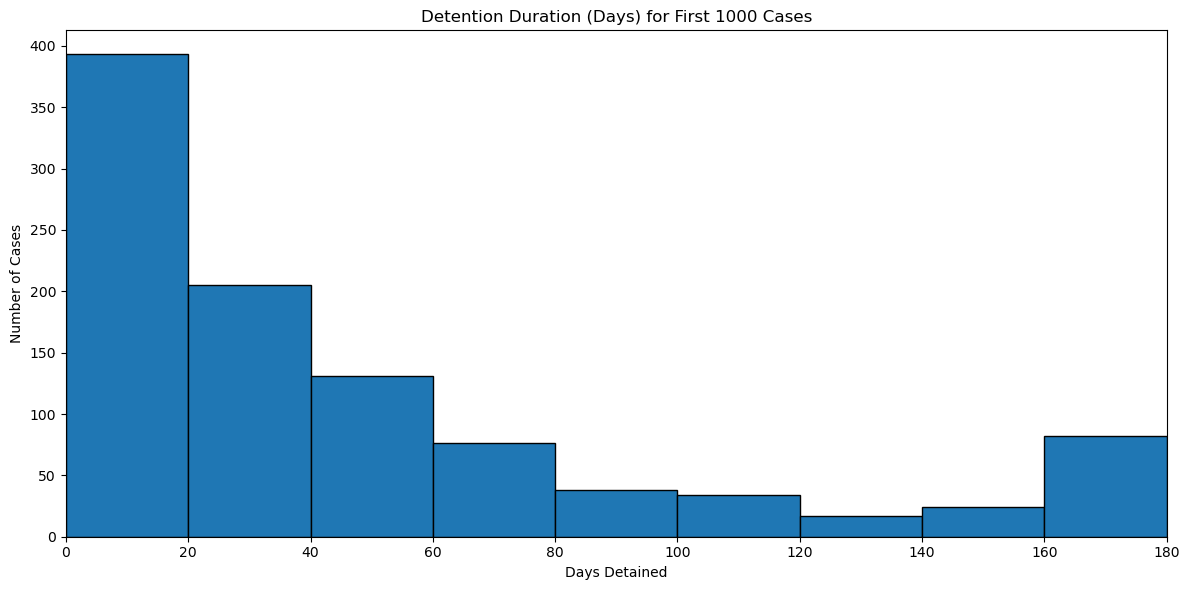

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# Filter valid detention cases (first 1000)
first_1000 = cases.dropna(subset=["DATE_DETAINED", "DATE_RELEASED"]).head(1000)
first_1000_detention_days = (
    first_1000["DATE_RELEASED"] - first_1000["DATE_DETAINED"]
).dt.days

# Calculate mean detention durations
detention_days = (cases["DATE_RELEASED"] - cases["DATE_DETAINED"]).dt.days
mean_detention_days = detention_days.mean()
mean_detention_days_first_1000 = first_1000_detention_days.mean()

# Print statistics
print(f"Mean detention days (all cases): {mean_detention_days:.2f}")
print(f"Mean detention days (first 1000 cases): {mean_detention_days_first_1000:.2f}")

# Define histogram bins
step = 20
max_days = first_1000_detention_days.max()
bins = np.arange(0, np.ceil(max_days) + step, step)

# Define bin size and max days
step = 20
max_days = first_1000_detention_days.max()

# Optional: Clip extreme values to improve visibility
max_plot = min(np.ceil(max_days), 180)  # show up to 180 days
bins = np.arange(0, max_plot + step, step)

# Plot histogram
plt.figure(figsize=(12, 6))
plt.hist(first_1000_detention_days.clip(upper=max_plot), bins=bins, edgecolor="black")

# Adjust x-axis ticks (every 20 days for better readability)
plt.xticks(np.arange(0, max_plot + 1, 20))

# Labels and layout
plt.title("Detention Duration (Days) for First 1000 Cases")
plt.xlabel("Days Detained")
plt.ylabel("Number of Cases")
plt.xlim(0, max_plot)
plt.tight_layout()
plt.show()

C:\Users\engam\AppData\Local\Temp\ipykernel_18360\2986115506.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_detained.groupby("CASE_TYPE")["DAYS_DETAINED"]
C:\Users\engam\AppData\Local\Temp\ipykernel_18360\2986115506.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


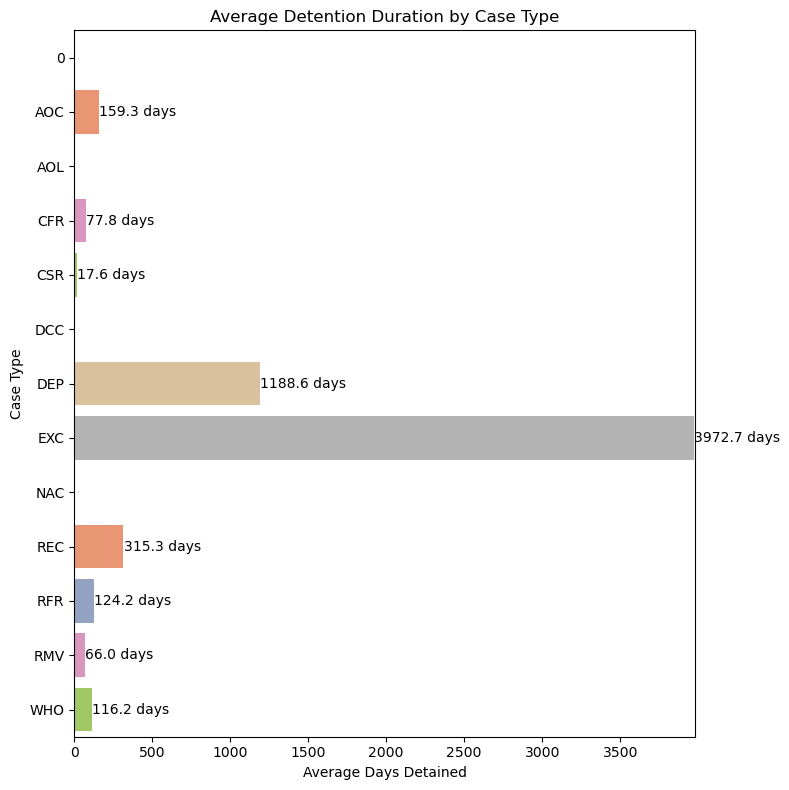

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Drop rows with missing or zero detention days
df_detained = cases.dropna(
    subset=["DATE_DETAINED", "DATE_RELEASED", "CASE_TYPE"]
).copy()
df_detained["DAYS_DETAINED"] = (
    df_detained["DATE_RELEASED"] - df_detained["DATE_DETAINED"]
).dt.days

# Keep only rows with positive detention duration
df_detained = df_detained[df_detained["DAYS_DETAINED"] > 0]

# Step 2: Group by CASE_TYPE and compute average, then sort descending
df_grouped = (
    df_detained.groupby("CASE_TYPE")["DAYS_DETAINED"]
    .mean()
    .sort_values(ascending=False)  # <-- key change
    .reset_index()
)

# Step 3: Plot
plt.figure(figsize=(8, 8))
ax = sns.barplot(y="CASE_TYPE", x="DAYS_DETAINED", data=df_grouped, palette="Set2")

# Step 4: Add data labels
for bar in ax.patches:
    ax.text(
        bar.get_width() + 0.5,
        bar.get_y() + bar.get_height() / 2,
        f"{bar.get_width():.1f} days",
        va="center",
    )

# Step 5: Customize and display
plt.title("Average Detention Duration by Case Type")
plt.xlabel("Average Days Detained")
plt.ylabel("Case Type")
plt.xlim(0, df_grouped["DAYS_DETAINED"].max() + 10)
plt.tight_layout()
plt.show()